In [1]:
import os
import pickle
import sys
from collections import Counter, defaultdict
from copy import deepcopy
from itertools import combinations, product
import pandas as pd
import json
import random

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import powerlaw
from joblib import Parallel, delayed
from matplotlib import colors
from networkx.algorithms.community.quality import modularity as nx_modularity
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.utils.testing import ignore_warnings
from tqdm.notebook import tqdm
from scipy.ndimage.measurements import label

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

sys.path.append('../../pygkernels')
from pygkernels.measure import kernels
from pygkernels.scenario import d3_colors

/home/illusionww/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def euclidean_distances(X, Y):
    X, Y = np.array(X), np.array(Y)
#     assert X.shape[1:] == Y.shape[1:], f'{X.shape}, {Y.shape}'
    result = np.sqrt(np.sum(np.power(X[:, None] - Y[None, :], 2), axis=2))
#     assert result.shape[0] == X.shape[0] and result.shape[1] == Y.shape[0], result.shape
    return result

In [3]:
class MyGaussianFilter:
    def __init__(self, sigma=0.05):
        self.sigma = sigma
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        
    def predict(self, X_test):
        output = []
        pair_distance = euclidean_distances(X_test, self.X)
        gaussian_weights = np.exp(-np.power(pair_distance, 2) / (2 * self.sigma**2))
        for test_idx in range(len(X_test)):
            chosen_indices = []
            for train_idx in range(len(self.X)):
                if pair_distance[test_idx, train_idx] < 3 * self.sigma:
                    chosen_indices.append(train_idx)
#             if len(chosen_indices) < 3:
#                 chosen_indices = []
            weighted_results = np.zeros(len(self.y[0]), dtype=np.float32)
            sum_weights = np.sum([gaussian_weights[test_idx, chosen_idx] for chosen_idx in chosen_indices])
            for chosen_idx in chosen_indices:
                weighted_results += gaussian_weights[test_idx, chosen_idx] * self.y[chosen_idx] / sum_weights
            output.append(weighted_results)
        return np.array(output)

In [24]:
def filter_on_points(X, y, sigma):
    knn = MyGaussianFilter(sigma=sigma)
    knn.fit(X, y)
    return knn.predict(X)

def filter_grid(X, y, sigma=0.05, resolution=11):
    dim = X.shape[1]
    
    knn = MyGaussianFilter(sigma=sigma)
    knn.fit(X, y)
    
    arr = np.zeros([resolution] * dim, dtype=np.float32)  # y_pred in nd
    for point in tqdm(product(*[range(resolution) for _ in range(dim)]), total=resolution ** dim):
        pred = knn.predict((np.array(point) / resolution)[None])[0]
        if ~np.all(pred == 0):
            arr[point] = np.argmax(pred)
        else:
            arr[point] = -1
    
    return arr

In [5]:
def prepare_plot_filter(X, y, sigma=0.05):
    knn = MyGaussianFilter(sigma=sigma)
    knn.fit(X, y)

    plot = np.zeros((resolution, resolution, 3), dtype=np.uint8)
    for xidx, xval in enumerate(np.linspace(0, 1, resolution)):
        for yidx, yval in enumerate(np.linspace(0, 1, resolution)):
            pixels_kernels_results = knn.predict([[xval, yval]])[0] 
            if ~np.all(pixels_kernels_results == 0):
                pixels_kernel_name = kernels_order[np.argmax(pixels_kernels_results)]
                plot[xidx, yidx] = np.array(colors.to_rgb(d3_colors[pixels_kernel_name])) * 255
            else:
                plot[xidx, yidx] = np.array([1, 1, 1]) * 255
            
    return plot

# 5d filter

In [6]:
kernels_order = np.array([x.name for x in kernels])
list(enumerate(kernels_order));

In [7]:
# root = '/media/illusionww/68949C3149F4E819/phd/pygkernels/montecarlo_lfr_simple'
# dataset = []
# for fn in tqdm(os.listdir(root)):
#     with open(f'{root}/{fn}', 'rb') as f:
#         dataset.append(json.load(f))
        
with open('filtered_dataset.json', 'r') as f:
    dataset = json.load(f)
    
idx_several_answers = [idx for idx, d in enumerate(dataset) 
                       if np.sum(np.max(np.array(list(d['measure_best_results'].values()))) == np.array(list(d['measure_best_results'].values()))) > 1]
idx_several_answers = set(idx_several_answers)

dataset = [d for idx, d in enumerate(dataset) if idx not in idx_several_answers]

In [8]:
all_feature_names = [
    'n',
    'tau1|sqrtinv',
    'tau2|sqrtinv',
    'avg_density',
    'modularity'
]

feature_min = {fn: np.min([data['estimated_params'][fn] for data in dataset]) for fn in all_feature_names}
feature_max = {fn: np.max([data['estimated_params'][fn] for data in dataset]) for fn in all_feature_names}
feature_width = {fn: feature_max[fn] - feature_min[fn] for fn in all_feature_names}
feature_normalize = lambda x, fn: (x - feature_min[fn]) / feature_width[fn]

for fn in all_feature_names:
    print(f'{fn}: {feature_min[fn]:.2f}, {feature_max[fn]:.2f} | '
          f'{feature_normalize(feature_min[fn], fn):.2f}, {feature_normalize(feature_max[fn], fn):.2f}')

n: 10.00, 1499.00 | 0.00, 1.00
tau1|sqrtinv: 0.27, 0.94 | 0.00, 1.00
tau2|sqrtinv: 0.19, 0.97 | 0.00, 1.00
avg_density: 0.00, 0.88 | 0.00, 1.00
modularity: -0.46, 0.84 | 0.00, 1.00


In [9]:
X = np.array([[feature_normalize(item['estimated_params'][fname], fname) for fname in all_feature_names] for item in dataset])
y = np.array([[item['measure_best_results'][kernel] for kernel in kernels_order] for item in dataset])

In [10]:
# draw 2d projections before filtering
prepare_plot_filter

<function __main__.prepare_plot_filter(X, y, sigma=0.05)>

In [11]:
structure = np.ones((3, 3, 3, 3, 3), dtype=np.int)  # this defines the connection filter

In [39]:
def calculate_components(sigma):
    y_pred = filter_grid(X, y, sigma=sigma, resolution=11)
    n_components = np.sum([label(y_pred == i, structure)[1] for i in range(25)])
    return sigma, n_components

results11 = Parallel(n_jobs=12)(delayed(calculate_components)(sigma) for sigma in tqdm(np.arange(0.03, 0.30, 0.01)))  # 0.034,

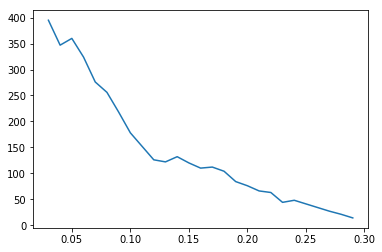

In [40]:
results11 = np.array(results11)
plt.plot(results11[:, 0], results11[:, 1])

In [41]:
def calculate_components(sigma):
    y_pred = filter_grid(X, y, sigma=sigma, resolution=21)
    n_components = np.sum([label(y_pred == i, structure)[1] for i in range(25)])
    return sigma, n_components

results21 = Parallel(n_jobs=12)(delayed(calculate_components)(sigma) for sigma in tqdm(np.arange(0.03, 0.30, 0.01)))  # 0.034,

KeyboardInterrupt: 

In [ ]:
results21 = np.array(results21)
plt.plot(results21[:, 0], results21[:, 1])